
# TP2 — Redes Neuronales

> **Alumnas:** Brigitte Blau y Micaela Bodner
> **Materia:** Seminario avanzado IA
:)





In [3]:


import os
import sys
import math
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers




In [6]:
from google.colab import files
uploaded = files.upload()

Saving adult.csv to adult.csv


In [7]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


df = pd.read_csv('adult.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [8]:


if 'income' not in df.columns:

    cand = [c for c in df.columns if c.lower() in ('income','class','target','label')]
    assert len(cand) == 1, f"No se encontró target unívoco, columnas: {df.columns}"
    df = df.rename(columns={cand[0]: 'income'})


df = df.dropna().reset_index(drop=True)


df['income'] = df['income'].astype(str).str.strip()

y = (df['income'] == '>50K').astype(int).values
X = df.drop(columns=['income'])


numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

print("Numéricas:", numeric_cols)
print("Categóricas:", categorical_cols)



Numéricas: ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
Categóricas: ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']


In [9]:

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.40,
    random_state=SEED,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=SEED,
    stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


preprocess = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
])


X_train_pp = preprocess.fit_transform(X_train)
X_val_pp   = preprocess.transform(X_val)
X_test_pp  = preprocess.transform(X_test)


X_train_pp = np.asarray(X_train_pp, dtype="float32")
X_val_pp   = np.asarray(X_val_pp, dtype="float32")
X_test_pp  = np.asarray(X_test_pp, dtype="float32")

y_train = np.asarray(y_train, dtype="float32")
y_val   = np.asarray(y_val, dtype="float32")
y_test  = np.asarray(y_test, dtype="float32")


input_dim = X_train_pp.shape[1]

print("X_train_pp:", X_train_pp.shape, X_train_pp.dtype)
print("y_train   :", y_train.shape, y_train.dtype)
print("input_dim :", input_dim)


Train: (19536, 14) Val: (6512, 14) Test: (6513, 14)
X_train_pp: (19536, 107) float32
y_train   : (19536,) float32
input_dim : 107




Creamos una función `build_model(**h)` y tres diccionarios de hiperparámetros:
- **Set A (chico):** 1 capa oculta (64), `dropout=0.0`, `lr=1e-3`
- **Set B (medio):** 2 capas (128, 64), `dropout=0.2`, `lr=5e-4`
- **Set C (grande):** 3 capas (256, 128, 64), `dropout=0.3`, `lr=3e-4`


In [10]:
hyperparams_list = [
    {
        "name": "Set A (chico)",
        "hidden_layers": [16],
        "epochs": 2,
        "batch_size": 256,
        "dropout": 0.0,
        "lr": 1e-3,
        "l2_reg": 0.0
    },
    {
        "name": "Set B (medio)",
        "hidden_layers": [32, 16],
        "epochs": 8,
        "batch_size": 256,
        "dropout": 0.2,
        "lr": 1e-3,
        "l2_reg": 1e-4
    },
    {
        "name": "Set C (grande)",
        "hidden_layers": [64, 32],
        "epochs": 10,
        "batch_size": 512,
        "dropout": 0.3,
        "lr": 5e-4,
        "l2_reg": 1e-3
    }
]



In [11]:
def build_model(input_dim, hidden_layers, dropout=0.0, lr=1e-3, l2_reg=0.0):
    model = keras.Sequential()

    for i, units in enumerate(hidden_layers):
        if i == 0:
            model.add(layers.Dense(
                units,
                activation="relu",
                input_shape=(input_dim,),
                kernel_regularizer=keras.regularizers.l2(l2_reg)
            ))
        else:
            model.add(layers.Dense(
                units,
                activation="relu",
                kernel_regularizer=keras.regularizers.l2(l2_reg)
            ))
        if dropout > 0:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [12]:
#tuvimos que hacer esto porque no andaba y no sabiamos si era de la funcion o del dataset
print("DIAGNÓSTICO DEL DATASET")
print(f"X_train_pp shape: {X_train_pp.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val_pp shape: {X_val_pp.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"Input dimension: {input_dim}")
print(f"Memoria aproximada X_train: {X_train_pp.nbytes / (1024**2):.2f} MB")

print("\nProbando crear primer modelo...")
test_model = build_model(
    input_dim=input_dim,
    hidden_layers=[16],
    dropout=0.0,
    lr=1e-3,
    l2_reg=0.0
)
print("Modelo creado exitosamente!")
test_model.summary()

print("\nProbando predicción dummy...")
import numpy as np
dummy_pred = test_model.predict(X_train_pp[:10], verbose=0)
print(f"Predicción dummy exitosa: {dummy_pred.shape}")


DIAGNÓSTICO DEL DATASET
X_train_pp shape: (19536, 107)
y_train shape: (19536,)
X_val_pp shape: (6512, 107)
y_val shape: (6512,)
Input dimension: 107
Memoria aproximada X_train: 7.97 MB

Probando crear primer modelo...
Modelo creado exitosamente!


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,745 (6.82 KB)

 Trainable params: 1,745 (6.82 KB)

 Non-trainable params: 0 (0.00 B)


Probando predicción dummy...
Predicción dummy exitosa: (10, 1)

Ahora iniciando entrenamiento real...




Entrenamos cada set con `EarlyStopping` monitorizando `val_loss`.  
Guardamos accuracy en validación y seleccionamos el mejor.


In [13]:
input_dim = X_train_pp.shape[1]

histories = {}
val_scores = []

for cfg in hyperparams_list:
    print("\n==============================")
    print("Entrenando:", cfg["name"])
    print("Capas ocultas:", cfg["hidden_layers"])

    model = build_model(
        input_dim=input_dim,
        hidden_layers=cfg["hidden_layers"],
        dropout=cfg["dropout"],
        lr=cfg["lr"],
        l2_reg=cfg["l2_reg"]
    )

    cb = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]

    history = model.fit(
        X_train_pp, y_train,
        validation_data=(X_val_pp, y_val),
        epochs=cfg["epochs"],
        batch_size=cfg["batch_size"],
        verbose=2,
        callbacks=cb
    )

    histories[cfg["name"]] = history.history


    val_pred = (model.predict(X_val_pp) >= 0.5).astype(int).ravel()
    val_acc = accuracy_score(y_val, val_pred)
    val_scores.append((cfg["name"], val_acc, model))

    print(f"Accuracy de validación ({cfg['name']}): {val_acc:.4f}")

val_scores.sort(key=lambda x: x[1], reverse=True)
best_name, best_val_acc, best_model = val_scores[0]
print("\nMejor set por validación:", best_name, "— acc:", round(best_val_acc, 4))


Entrenando: Set A (chico)
Capas ocultas: [16]
Epoch 1/2
77/77 - 2s - 31ms/step - accuracy: 0.7098 - loss: 0.5731 - val_accuracy: 0.8080 - val_loss: 0.4404
Epoch 2/2
77/77 - 1s - 10ms/step - accuracy: 0.8334 - loss: 0.3817 - val_accuracy: 0.8400 - val_loss: 0.3525
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy de validación (Set A (chico)): 0.8400

Entrenando: Set B (medio)
Capas ocultas: [32, 16]


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/8
77/77 - 6s - 78ms/step - accuracy: 0.7695 - loss: 0.5139 - val_accuracy: 0.8259 - val_loss: 0.3843
Epoch 2/8
77/77 - 1s - 11ms/step - accuracy: 0.8329 - loss: 0.3676 - val_accuracy: 0.8428 - val_loss: 0.3428
Epoch 3/8
77/77 - 0s - 4ms/step - accuracy: 0.8435 - loss: 0.3457 - val_accuracy: 0.8487 - val_loss: 0.3339
Epoch 4/8
77/77 - 0s - 4ms/step - accuracy: 0.8505 - loss: 0.3317 - val_accuracy: 0.8483 - val_loss: 0.3306
Epoch 5/8
77/77 - 0s - 4ms/step - accuracy: 0.8517 - loss: 0.3284 - val_accuracy: 0.8471 - val_loss: 0.3296
Epoch 6/8
77/77 - 0s - 4ms/step - accuracy: 0.8535 - loss: 0.3255 - val_accuracy: 0.8490 - val_loss: 0.3279
Epoch 7/8
77/77 - 0s - 4ms/step - accuracy: 0.8577 - loss: 0.3209 - val_accuracy: 0.8503 - val_loss: 0.3268
Epoch 8/8
77/77 - 0s - 4ms/step - accuracy: 0.8568 - loss: 0.3193 - val_accuracy: 0.8492 - val_loss: 0.3261
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy de validación (Set B (medio)): 0.8492

Entrenando: Set C (grande)
Capas ocultas: [64

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 - 2s - 45ms/step - accuracy: 0.6567 - loss: 0.7476 - val_accuracy: 0.7597 - val_loss: 0.6060
Epoch 2/10
39/39 - 0s - 7ms/step - accuracy: 0.7854 - loss: 0.5655 - val_accuracy: 0.8173 - val_loss: 0.4893
Epoch 3/10
39/39 - 0s - 6ms/step - accuracy: 0.8161 - loss: 0.4891 - val_accuracy: 0.8374 - val_loss: 0.4433
Epoch 4/10
39/39 - 0s - 7ms/step - accuracy: 0.8299 - loss: 0.4512 - val_accuracy: 0.8404 - val_loss: 0.4246
Epoch 5/10
39/39 - 0s - 7ms/step - accuracy: 0.8386 - loss: 0.4298 - val_accuracy: 0.8429 - val_loss: 0.4125
Epoch 6/10
39/39 - 0s - 7ms/step - accuracy: 0.8398 - loss: 0.4179 - val_accuracy: 0.8452 - val_loss: 0.4031
Epoch 7/10
39/39 - 0s - 6ms/step - accuracy: 0.8456 - loss: 0.4063 - val_accuracy: 0.8461 - val_loss: 0.3959
Epoch 8/10
39/39 - 0s - 6ms/step - accuracy: 0.8459 - loss: 0.3982 - val_accuracy: 0.8471 - val_loss: 0.3898
Epoch 9/10
39/39 - 0s - 6ms/step - accuracy: 0.8509 - loss: 0.3917 - val_accuracy: 0.8467 - val_loss: 0.3847
Epoch 10/10
39/39 - 0s - 7ms/


### Curvas de entrenamiento (loss y accuracy)


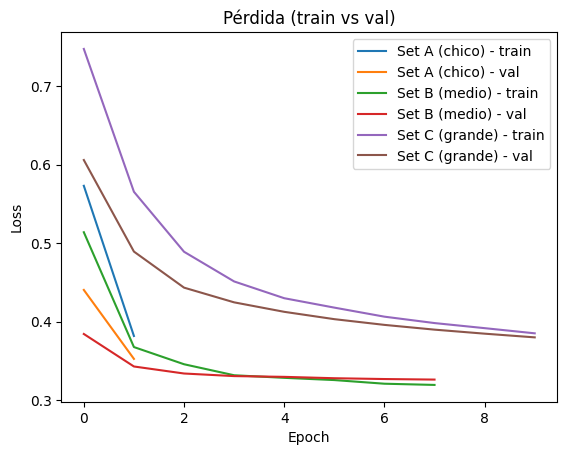

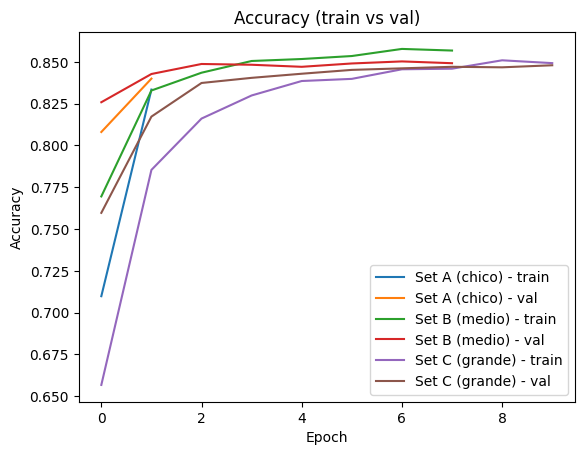

In [14]:

plt.figure()
for name, hist in histories.items():
    plt.plot(hist['loss'], label=f"{name} - train")
    plt.plot(hist['val_loss'], label=f"{name} - val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Pérdida (train vs val)")
plt.legend()
plt.show()

plt.figure()
for name, hist in histories.items():
    plt.plot(hist['accuracy'], label=f"{name} - train")
    plt.plot(hist['val_accuracy'], label=f"{name} - val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy (train vs val)")
plt.legend()
plt.show()


In [15]:

test_pred = (best_model.predict(X_test_pp) >= 0.5).astype(int).ravel()
test_acc = accuracy_score(y_test, test_pred)
print(f"Accuracy en test con '{best_name}': {test_acc:.4f}")

cm = confusion_matrix(y_test, test_pred)
print("\nMatriz de confusión:\n", cm)
print("\nReporte de clasificación:\n", classification_report(y_test, test_pred, digits=4))


204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy en test con 'Set B (medio)': 0.8521

Matriz de confusión:
 [[4602  342]
 [ 621  948]]

Reporte de clasificación:
               precision    recall  f1-score   support

         0.0     0.8811    0.9308    0.9053      4944
         1.0     0.7349    0.6042    0.6632      1569

    accuracy                         0.8521      6513
   macro avg     0.8080    0.7675    0.7842      6513
weighted avg     0.8459    0.8521    0.8470      6513



# Comparación con el tp anterior

- Regresión logística: _accuracy = 0.8125703756781656
- Árbol de decisión: _accuracy =  0.8117514586958747



- **Set A (chico)**: Mínimo overfitting, pero menor capacidad (84.00% val)
- **Set B (medio)**: **Mejor generalización** - curvas train/val muy cercanas, convergencia estable
- **Set C (grande)**: Ligero overfitting visible - mayor gap entre train y val, especialmente en loss

El set b fue el mejor y paso tambien a la regresión logistica y árbol de decisión.  
